##### Copyright 2023 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a Deep Q Network with TF-Agents

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/1_dqn_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction


This example shows how to train a [DQN (Deep Q Networks)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)  agent on the Cartpole environment using the TF-Agents library.

![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)

It will walk you through all the components in a Reinforcement Learning (RL) pipeline for training, evaluation and data collection.


To run this code live, click the 'Run in Google Colab' link above.


## Setup

If you haven't installed the following dependencies, run:

In [2]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,143 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,861 kB]
Get:13 http://archive.ubuntu.com/u

In [3]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [4]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2025-11-17 01:31:23.322480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-17 01:31:23.322556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-17 01:31:23.324458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/r

In [5]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [6]:
tf.version.VERSION

'2.15.1'

## Hyperparameters

Con leves cambios por la complejidad del sistema

In [7]:
num_iterations = 40000 # @param {type:"integer"}

initial_collect_steps = 500  # @param {type:"integer"}
collect_steps_per_iteration =  1 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 2000  # @param {type:"integer"}

## Environment

In [8]:
env_name = 'Acrobot-v1'
env = suite_gym.load(env_name)

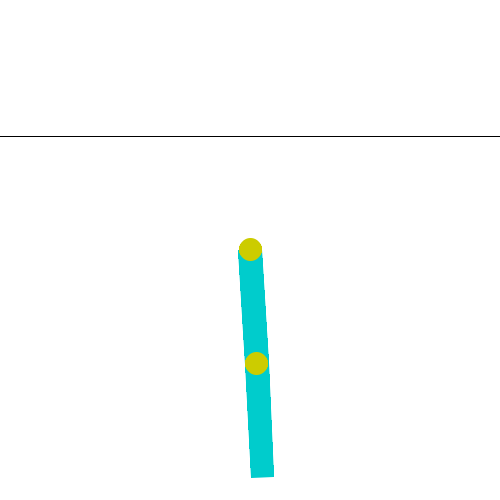

In [9]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

In [10]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(6,), dtype=dtype('float32'), name='observation', minimum=[ -1.        -1.        -1.        -1.       -12.566371 -28.274334], maximum=[ 1.        1.        1.        1.       12.566371 28.274334])


In [11]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [12]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


In the Acrobot environment:

-   `observation` is an array of 6 floats: 
   the angles for the movement of the chain.
    angular velocity 1
    angular velocity 2 
-   `reward` is a scalar float value 
-   `action` is a scalar integer with only two limits: minimun = -1, maximum = 0. 

The agent only takes discret decisions: 
- 0: aply negative torque. 
- 1: not aply torque.
- 2: aply positive torque.

In [13]:
time_step = env.reset() #resetear el ambiente 
print('Time step:') #imprimir información
print(time_step)

action = np.array(2, dtype=np.int32) #Se define la accion que va a tomar el entorno 

next_time_step = env.step(action) #ejecutar un paso en el ambiente
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.9976427 ,  0.06862231,  0.9990992 , -0.04243642, -0.08347086,
        0.03889707], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(-1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.99953955,  0.03034342,  0.99995494,  0.00949362, -0.29015526,
        0.46516573], dtype=float32)})


## Entrenamiento y evaluación del modelo

In [14]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [15]:
#convertir a tensorflow para usar los agentes y policies
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [16]:
fc_layer_params = (100, 50) #tamaños de las capas densas
action_tensor_spec = tensor_spec.from_spec(env.action_spec()) #cuántas acciones, limites y tipo de datos
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1 # número total de acciones

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer. Activación con ReLU
def dense_layer(num_units): 
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense( #ultima capa de la rede neuronal
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [17]:
#agregar optimizador que calcule los gradientes del loss, actualizar los pesos de la red y permitir que el agente aprenda
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Adam es un tipo de optimizador para el RL

train_step_counter = tf.Variable(0) #contador de pasos

#crear el agente DQN
agent = dqn_agent.DqnAgent( 
    train_env.time_step_spec(), #describir el entorno
    train_env.action_spec(), #describe las acciones posibles del entorno 
    q_network=q_net,#red neuronal
    optimizer=optimizer,#qué método usar para entrenar la red Q 
    td_errors_loss_fn=common.element_wise_squared_loss, #función de pérdida MSE
    train_step_counter=train_step_counter) #contador de pasos global

agent.initialize() #inicializar el agante

## Policies

In [18]:
eval_policy = agent.policy #politica aprendida del agente - politica explotadora :v
#se usa para evaluar el rendimiento del modelo sin explorar 

collect_policy = agent.collect_policy #alimenta el buffer con experiencias para que el agente aprenda 

In [19]:
#experiencias aleatorias
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [20]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('Acrobot-v1'))

In [21]:
time_step = example_environment.reset()

In [22]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>, state=(), info=())

## Evaluación

In [23]:
#@test {"skip": true} Evalua qué tan buena es una política ejecutando varias veces
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0 #inicializa el el acumulador
  for _ in range(num_episodes): #repetir episodios

    time_step = environment.reset()
    episode_return = 0.0 #reiniciar el ambiente y guardar recompensa

    while not time_step.is_last(): #ejecuta hasta terminar episodio
      action_step = policy.action(time_step) #tomar una acción
      time_step = environment.step(action_step.action) #avanzar el ambiente
      episode_return += time_step.reward #acumular recompensa
    total_return += episode_return #acumular los episodios

  avg_return = total_return / num_episodes #calcular el promedio
  return avg_return.numpy()[0]

In [24]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-500.0

## Replay Buffer

In [25]:
## Guardar los datos para que el agente pueda aprenderlos
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpxqvtxa2m.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpxqvtxa2m
[reverb/cc/platform/default/server.cc:71] Started replay server on port 32909


In [26]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [27]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

In [28]:
#@test {"skip": true}
#generar datos de experiencia para entrenar al agente
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([ 0.99934256,  0.03625454,  0.99998444,  0.00558235, -0.1995566 ,
         0.47897005], dtype=float32)}),
 ())

In [29]:
# Dataset donde se guardan las experiencias para que el agente aprenda
#
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 6), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [30]:
iterator = iter(dataset)
print(iterator)

In [31]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [32]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (13) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (13) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (13) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (13) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (13) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (13) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 9.67911148071289
step = 400: loss = 6.880888938903809
step = 600: loss = 16.917844772338867
step = 800: loss = 30.44588851928711
step = 1000: loss = 22.558605194091797
step = 1200: loss = 9.051519393920898
step = 1400: loss = 10.123960494995117
step = 1600: loss = 7.259739875793457
step = 1800: loss = 11.736495971679688
step = 2000: loss = 6.445037841796875
step = 2000: Average Return = -295.29998779296875
step = 2200: loss = 6.748085975646973
step = 2400: loss = 14.258177757263184
step = 2600: loss = 6.009081840515137
step = 2800: loss = 3.6834259033203125
step = 3000: loss = 5.438529968261719
step = 3200: loss = 9.756218910217285
step = 3400: loss = 11.081802368164062
step = 3600: loss = 5.267535209655762
step = 3800: loss = 7.290958881378174
step = 4000: loss = 5.295349597930908
step = 4000: Average Return = -129.89999389648438
step = 4200: loss = 4.322332859039307
step = 4400: loss = 8.993387222290039
step = 4600: loss = 5.486756324768066
step = 4800: loss = 4.35

## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(-520.675, 250.0)

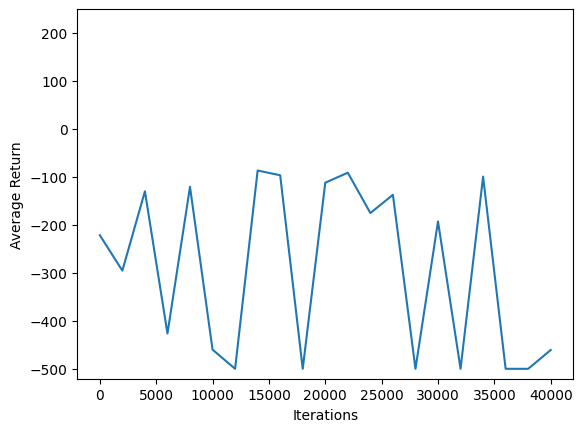

In [33]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [34]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [35]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x5c93b7602a40] Warning: data is not aligned! This can lead to a speed loss


For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [36]:
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x59809ebb9a40] Warning: data is not aligned! This can lead to a speed loss
